In [1]:

###############################################
# CUHK STAT3009 Recommender Systems Project 1 #
###############################################

import numpy as np
import pandas as pd

dtrain = pd.read_csv('train.csv', usecols=['user_id', 'item_id', 'rating'])
dtest = pd.read_csv('test.csv', usecols=['user_id', 'item_id'])
sub = pd.read_csv('sample_submission.csv')

train_pair = dtrain[["user_id", "item_id"]].values
train_rating = np.array(dtrain["rating"])
test_pair = dtest[["user_id", "item_id"]].values

n_user = max(max(train_pair[:,0]), max(test_pair[:,0])) + 1
print('number of users: %d' %n_user)
n_item = max(max(train_pair[:,1]), max(test_pair[:,1])) + 1
print('number of items: %d' %n_item)

def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

number of users: 500
number of items: 1000


In [8]:
set(dtrain["user_id"]).symmetric_difference(set(dtest["user_id"]))

{0,
 1,
 2,
 4,
 5,
 7,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 19,
 22,
 24,
 25,
 26,
 28,
 29,
 31,
 34,
 36,
 37,
 39,
 41,
 42,
 48,
 60,
 64,
 106,
 120,
 122,
 133,
 149,
 165,
 196,
 219,
 236,
 246,
 374,
 402,
 408,
 437,
 452,
 461,
 490}

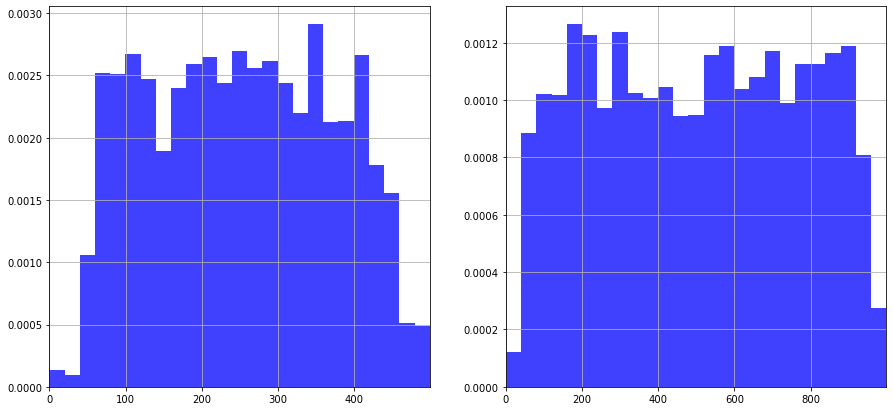

In [2]:
#EDA for the users and items
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.hist(dtrain["user_id"], 25, density=True, facecolor='b', alpha=0.75)
ax1.set(xlim = [min(dtrain["user_id"]), max(dtrain["user_id"])])
ax1.grid(True)

ax2.hist(dtrain["item_id"], 25, density=True, facecolor='b', alpha=0.75)
ax2.set(xlim = [min(dtrain["item_id"]), max(dtrain["item_id"])])
ax2.grid(True)

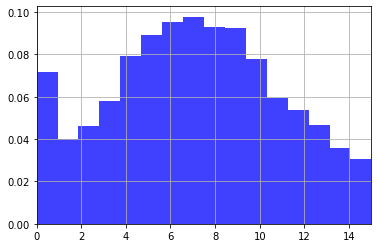

In [3]:
#EDA for the ratings
plt.hist(dtrain["rating"], len(dtrain["rating"].unique()), density=True, facecolor='b', alpha=0.75)
plt.xlim(min(dtrain["rating"]), max(dtrain["rating"]))
plt.grid(True)

In [4]:
freq_item = []
freq_user = []

index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]

for i in range(n_item):
    freq_item.append(len(index_item[i]))
    
for i in range(n_user):
    freq_user.append(len(index_user[i]))

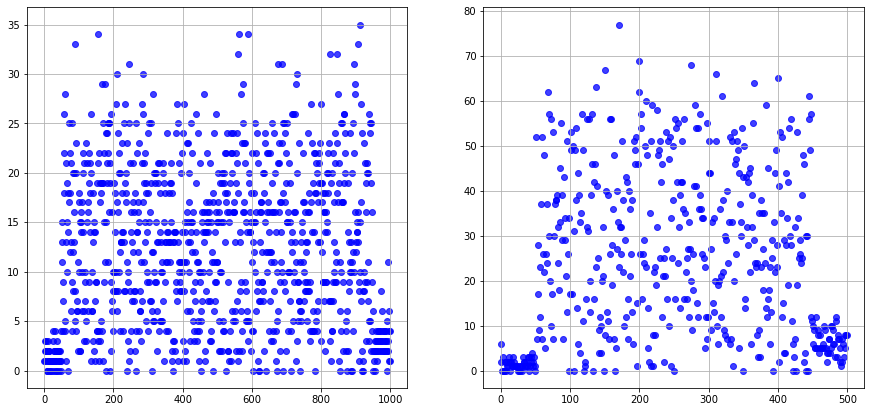

In [5]:
#EDA for the scatter plot of ID vs Freq
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.scatter(range(n_item), freq_item,  facecolor='b', alpha=0.75)
ax1.grid(True)

ax2.scatter(range(n_user), freq_user, facecolor='b', alpha=0.75)
ax2.grid(True)

In [6]:
# save indices for all users/items
index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]

In [7]:
class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, GDiterNum=10, tol=1e-4):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.GDiterNum = GDiterNum
        self.tol = tol

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                train_pair_tmp, train_rating_tmp = train_pair[index_item_tmp], train_rating[index_item_tmp]
                ## GD block
                for h in range(self.GDiterNum):
                  ## compute res on the current model
                  err_tmp = train_rating_tmp - self.predict(test_pair=train_pair_tmp)
                  sum_pu = np.sum(self.P[train_pair_tmp[:,0]] * err_tmp[:,np.newaxis], 0) / n_obs
                  ## GD updates for Q
                  self.Q[item_id] = self.Q[item_id] + 2*learning_rate*sum_pu - 2*learning_rate*lam*self.Q[item_id]
                
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                train_pair_tmp, train_rating_tmp = train_pair[index_user_tmp], train_rating[index_user_tmp]
                for h in range(self.GDiterNum):
                  ## compute res on the current model
                  err_tmp = train_rating_tmp - self.predict(test_pair=train_pair_tmp)
                  sum_qi = np.sum(self.Q[train_pair_tmp[:,1]] * err_tmp[:,np.newaxis], 0) / n_obs
                  ## GD updates for Q
                  self.P[user_id] = self.P[user_id] + 2*learning_rate*sum_qi - 2*learning_rate*lam*self.P[user_id]

            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            rmse_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - obj_new + obj_old
            print("Reg-MF: GD - ite: %d; diff: %f; Obj: %f; RMSE: %f" %(i, diff, obj_new, rmse_new))
            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)

    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [8]:
# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred

In [9]:
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class MF_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = MF(self.n_user, self.n_item, K=K, lam=lam)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv, learning_rate=1)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %f: train_rmse: %f, valid_rmse: %f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

In [10]:
#Set grids
folds = 5
Ks, lams = np.arange(1, 51, 1), 10**np.arange(-3, 3, .5)

In [ ]:
## Baseline `glb mean based and user fitted` + MF
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_rating = glb_ave.predict(test_pair)

# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred_rating = pred_rating + user_ave.predict(test_pair)

#Grid Search
shiing_cv = MF_CV(n_user, n_item, cv=folds, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=MF(n_user, n_item, K=best_K, lam=best_lam, learning_rate=1)
shiing.fit(train_pair, train_rating_res)
pred_rating = pred_rating + shiing.predict(test_pair)

Fitting Reg-MF: K: 1, lam: 0.00100
Reg-MF: GD - ite: 0; diff: 0.477295; Obj: 13.316585; RMSE: 3.470523
Reg-MF: GD - ite: 1; diff: 0.300767; Obj: 13.015818; RMSE: 3.440922
Reg-MF: GD - ite: 2; diff: 0.234587; Obj: 12.781231; RMSE: 3.418429
Reg-MF: GD - ite: 3; diff: 0.188175; Obj: 12.593056; RMSE: 3.400817
Reg-MF: GD - ite: 4; diff: 0.154612; Obj: 12.438444; RMSE: 3.386644
Reg-MF: GD - ite: 5; diff: 0.129752; Obj: 12.308692; RMSE: 3.374936
Reg-MF: GD - ite: 6; diff: 0.110995; Obj: 12.197697; RMSE: 3.365016
Reg-MF: GD - ite: 7; diff: 0.096654; Obj: 12.101043; RMSE: 3.356395
Reg-MF: GD - ite: 8; diff: 0.085595; Obj: 12.015447; RMSE: 3.348711
Reg-MF: GD - ite: 9; diff: 0.077043; Obj: 11.938404; RMSE: 3.341685
Reg-MF: GD - ite: 10; diff: 0.070452; Obj: 11.867952; RMSE: 3.335099
Reg-MF: GD - ite: 11; diff: 0.065436; Obj: 11.802516; RMSE: 3.328776
Reg-MF: GD - ite: 12; diff: 0.061716; Obj: 11.740800; RMSE: 3.322565
Reg-MF: GD - ite: 13; diff: 0.059090; Obj: 11.681710; RMSE: 3.316337
Reg-MF: G

Reg-MF: GD - ite: 120; diff: 0.000629; Obj: 5.866166; RMSE: 1.729508
Reg-MF: GD - ite: 121; diff: 0.000591; Obj: 5.865575; RMSE: 1.728538
Reg-MF: GD - ite: 122; diff: 0.000556; Obj: 5.865018; RMSE: 1.727607
Reg-MF: GD - ite: 123; diff: 0.000524; Obj: 5.864495; RMSE: 1.726714
Reg-MF: GD - ite: 124; diff: 0.000493; Obj: 5.864001; RMSE: 1.725856
Reg-MF: GD - ite: 125; diff: 0.000465; Obj: 5.863537; RMSE: 1.725033
Reg-MF: GD - ite: 126; diff: 0.000438; Obj: 5.863098; RMSE: 1.724242
Reg-MF: GD - ite: 127; diff: 0.000413; Obj: 5.862685; RMSE: 1.723482
Reg-MF: GD - ite: 128; diff: 0.000390; Obj: 5.862294; RMSE: 1.722752
Reg-MF: GD - ite: 129; diff: 0.000369; Obj: 5.861926; RMSE: 1.722050
Reg-MF: GD - ite: 130; diff: 0.000348; Obj: 5.861578; RMSE: 1.721375
Reg-MF: GD - ite: 131; diff: 0.000329; Obj: 5.861249; RMSE: 1.720726
Reg-MF: GD - ite: 132; diff: 0.000311; Obj: 5.860938; RMSE: 1.720101
Reg-MF: GD - ite: 133; diff: 0.000294; Obj: 5.860643; RMSE: 1.719500
Reg-MF: GD - ite: 134; diff: 0.000

Reg-MF: GD - ite: 82; diff: 0.076429; Obj: 7.365731; RMSE: 2.348473
Reg-MF: GD - ite: 83; diff: 0.074230; Obj: 7.291501; RMSE: 2.325866
Reg-MF: GD - ite: 84; diff: 0.072011; Obj: 7.219490; RMSE: 2.303625
Reg-MF: GD - ite: 85; diff: 0.069780; Obj: 7.149710; RMSE: 2.281767
Reg-MF: GD - ite: 86; diff: 0.067542; Obj: 7.082168; RMSE: 2.260308
Reg-MF: GD - ite: 87; diff: 0.065303; Obj: 7.016865; RMSE: 2.239262
Reg-MF: GD - ite: 88; diff: 0.063067; Obj: 6.953798; RMSE: 2.218641
Reg-MF: GD - ite: 89; diff: 0.060840; Obj: 6.892958; RMSE: 2.198459
Reg-MF: GD - ite: 90; diff: 0.058625; Obj: 6.834333; RMSE: 2.178725
Reg-MF: GD - ite: 91; diff: 0.056425; Obj: 6.777908; RMSE: 2.159449
Reg-MF: GD - ite: 92; diff: 0.054244; Obj: 6.723664; RMSE: 2.140642
Reg-MF: GD - ite: 93; diff: 0.052085; Obj: 6.671580; RMSE: 2.122311
Reg-MF: GD - ite: 94; diff: 0.049950; Obj: 6.621630; RMSE: 2.104464
Reg-MF: GD - ite: 95; diff: 0.047841; Obj: 6.573788; RMSE: 2.087107
Reg-MF: GD - ite: 96; diff: 0.045761; Obj: 6.528

Reg-MF: GD - ite: 7; diff: 0.091059; Obj: 12.124060; RMSE: 3.359790
Reg-MF: GD - ite: 8; diff: 0.079206; Obj: 12.044854; RMSE: 3.353250
Reg-MF: GD - ite: 9; diff: 0.069734; Obj: 11.975120; RMSE: 3.347557
Reg-MF: GD - ite: 10; diff: 0.062074; Obj: 11.913046; RMSE: 3.342521
Reg-MF: GD - ite: 11; diff: 0.055812; Obj: 11.857234; RMSE: 3.337992
Reg-MF: GD - ite: 12; diff: 0.050646; Obj: 11.806588; RMSE: 3.333857
Reg-MF: GD - ite: 13; diff: 0.046350; Obj: 11.760238; RMSE: 3.330027
Reg-MF: GD - ite: 14; diff: 0.042751; Obj: 11.717487; RMSE: 3.326430
Reg-MF: GD - ite: 15; diff: 0.039717; Obj: 11.677770; RMSE: 3.323011
Reg-MF: GD - ite: 16; diff: 0.037145; Obj: 11.640625; RMSE: 3.319724
Reg-MF: GD - ite: 17; diff: 0.034954; Obj: 11.605671; RMSE: 3.316531
Reg-MF: GD - ite: 18; diff: 0.033080; Obj: 11.572591; RMSE: 3.313402
Reg-MF: GD - ite: 19; diff: 0.031469; Obj: 11.541121; RMSE: 3.310312
Reg-MF: GD - ite: 20; diff: 0.030082; Obj: 11.511040; RMSE: 3.307241
Reg-MF: GD - ite: 21; diff: 0.028881;

Reg-MF: GD - ite: 126; diff: 0.064112; Obj: 6.837351; RMSE: 2.173041
Reg-MF: GD - ite: 127; diff: 0.061054; Obj: 6.776297; RMSE: 2.152399
Reg-MF: GD - ite: 128; diff: 0.058001; Obj: 6.718295; RMSE: 2.132428
Reg-MF: GD - ite: 129; diff: 0.054974; Obj: 6.663322; RMSE: 2.113147
Reg-MF: GD - ite: 130; diff: 0.051988; Obj: 6.611334; RMSE: 2.094572
Reg-MF: GD - ite: 131; diff: 0.049061; Obj: 6.562272; RMSE: 2.076713
Reg-MF: GD - ite: 132; diff: 0.046207; Obj: 6.516065; RMSE: 2.059572
Reg-MF: GD - ite: 133; diff: 0.043439; Obj: 6.472626; RMSE: 2.043151
Reg-MF: GD - ite: 134; diff: 0.040766; Obj: 6.431860; RMSE: 2.027445
Reg-MF: GD - ite: 135; diff: 0.038198; Obj: 6.393662; RMSE: 2.012444
Reg-MF: GD - ite: 136; diff: 0.035742; Obj: 6.357920; RMSE: 1.998136
Reg-MF: GD - ite: 137; diff: 0.033402; Obj: 6.324518; RMSE: 1.984505
Reg-MF: GD - ite: 138; diff: 0.031181; Obj: 6.293337; RMSE: 1.971532
Reg-MF: GD - ite: 139; diff: 0.029083; Obj: 6.264254; RMSE: 1.959196
Reg-MF: GD - ite: 140; diff: 0.027

Reg-MF: GD - ite: 13; diff: 0.047741; Obj: 11.753363; RMSE: 3.331238
Reg-MF: GD - ite: 14; diff: 0.043932; Obj: 11.709431; RMSE: 3.327352
Reg-MF: GD - ite: 15; diff: 0.040752; Obj: 11.668679; RMSE: 3.323653
Reg-MF: GD - ite: 16; diff: 0.038092; Obj: 11.630586; RMSE: 3.320089
Reg-MF: GD - ite: 17; diff: 0.035867; Obj: 11.594719; RMSE: 3.316616
Reg-MF: GD - ite: 18; diff: 0.034011; Obj: 11.560708; RMSE: 3.313197
Reg-MF: GD - ite: 19; diff: 0.032470; Obj: 11.528239; RMSE: 3.309799
Reg-MF: GD - ite: 20; diff: 0.031203; Obj: 11.497036; RMSE: 3.306394
Reg-MF: GD - ite: 21; diff: 0.030177; Obj: 11.466859; RMSE: 3.302956
Reg-MF: GD - ite: 22; diff: 0.029367; Obj: 11.437492; RMSE: 3.299462
Reg-MF: GD - ite: 23; diff: 0.028752; Obj: 11.408740; RMSE: 3.295890
Reg-MF: GD - ite: 24; diff: 0.028318; Obj: 11.380422; RMSE: 3.292220
Reg-MF: GD - ite: 25; diff: 0.028051; Obj: 11.352370; RMSE: 3.288432
Reg-MF: GD - ite: 26; diff: 0.027945; Obj: 11.324425; RMSE: 3.284504
Reg-MF: GD - ite: 27; diff: 0.0279

Reg-MF: GD - ite: 133; diff: 0.001120; Obj: 5.840040; RMSE: 1.736274
Reg-MF: GD - ite: 134; diff: 0.001044; Obj: 5.838996; RMSE: 1.734828
Reg-MF: GD - ite: 135; diff: 0.000973; Obj: 5.838023; RMSE: 1.733444
Reg-MF: GD - ite: 136; diff: 0.000907; Obj: 5.837115; RMSE: 1.732121
Reg-MF: GD - ite: 137; diff: 0.000846; Obj: 5.836269; RMSE: 1.730855
Reg-MF: GD - ite: 138; diff: 0.000790; Obj: 5.835479; RMSE: 1.729644
Reg-MF: GD - ite: 139; diff: 0.000737; Obj: 5.834742; RMSE: 1.728485
Reg-MF: GD - ite: 140; diff: 0.000688; Obj: 5.834054; RMSE: 1.727375
Reg-MF: GD - ite: 141; diff: 0.000643; Obj: 5.833411; RMSE: 1.726312
Reg-MF: GD - ite: 142; diff: 0.000600; Obj: 5.832811; RMSE: 1.725294
Reg-MF: GD - ite: 143; diff: 0.000561; Obj: 5.832250; RMSE: 1.724318
Reg-MF: GD - ite: 144; diff: 0.000524; Obj: 5.831725; RMSE: 1.723383
Reg-MF: GD - ite: 145; diff: 0.000490; Obj: 5.831235; RMSE: 1.722487
Reg-MF: GD - ite: 146; diff: 0.000458; Obj: 5.830777; RMSE: 1.721628
Reg-MF: GD - ite: 147; diff: 0.000

Reg-MF: GD - ite: 80; diff: 0.006856; Obj: 5.929898; RMSE: 1.805214
Reg-MF: GD - ite: 81; diff: 0.006306; Obj: 5.923591; RMSE: 1.800180
Reg-MF: GD - ite: 82; diff: 0.005807; Obj: 5.917784; RMSE: 1.795423
Reg-MF: GD - ite: 83; diff: 0.005352; Obj: 5.912432; RMSE: 1.790926
Reg-MF: GD - ite: 84; diff: 0.004937; Obj: 5.907495; RMSE: 1.786671
Reg-MF: GD - ite: 85; diff: 0.004559; Obj: 5.902937; RMSE: 1.782642
Reg-MF: GD - ite: 86; diff: 0.004213; Obj: 5.898724; RMSE: 1.778825
Reg-MF: GD - ite: 87; diff: 0.003896; Obj: 5.894828; RMSE: 1.775207
Reg-MF: GD - ite: 88; diff: 0.003607; Obj: 5.891221; RMSE: 1.771774
Reg-MF: GD - ite: 89; diff: 0.003341; Obj: 5.887880; RMSE: 1.768515
Reg-MF: GD - ite: 90; diff: 0.003097; Obj: 5.884783; RMSE: 1.765420
Reg-MF: GD - ite: 91; diff: 0.002873; Obj: 5.881909; RMSE: 1.762479
Reg-MF: GD - ite: 92; diff: 0.002668; Obj: 5.879242; RMSE: 1.759683
Reg-MF: GD - ite: 93; diff: 0.002478; Obj: 5.876763; RMSE: 1.757022
Reg-MF: GD - ite: 94; diff: 0.002304; Obj: 5.874

Reg-MF: GD - ite: 52; diff: 0.006372; Obj: 11.304114; RMSE: 3.338057
Reg-MF: GD - ite: 53; diff: 0.006837; Obj: 11.297277; RMSE: 3.336142
Reg-MF: GD - ite: 54; diff: 0.007356; Obj: 11.289921; RMSE: 3.334022
Reg-MF: GD - ite: 55; diff: 0.007931; Obj: 11.281990; RMSE: 3.331679
Reg-MF: GD - ite: 56; diff: 0.008565; Obj: 11.273425; RMSE: 3.329093
Reg-MF: GD - ite: 57; diff: 0.009260; Obj: 11.264165; RMSE: 3.326243
Reg-MF: GD - ite: 58; diff: 0.010018; Obj: 11.254147; RMSE: 3.323108
Reg-MF: GD - ite: 59; diff: 0.010842; Obj: 11.243305; RMSE: 3.319663
Reg-MF: GD - ite: 60; diff: 0.011732; Obj: 11.231572; RMSE: 3.315885
Reg-MF: GD - ite: 61; diff: 0.012691; Obj: 11.218881; RMSE: 3.311747
Reg-MF: GD - ite: 62; diff: 0.013717; Obj: 11.205164; RMSE: 3.307221
Reg-MF: GD - ite: 63; diff: 0.014812; Obj: 11.190352; RMSE: 3.302281
Reg-MF: GD - ite: 64; diff: 0.015973; Obj: 11.174379; RMSE: 3.296896
Reg-MF: GD - ite: 65; diff: 0.017198; Obj: 11.157181; RMSE: 3.291037
Reg-MF: GD - ite: 66; diff: 0.0184

Reg-MF: GD - ite: 20; diff: 0.029369; Obj: 11.537195; RMSE: 3.339705
Reg-MF: GD - ite: 21; diff: 0.025790; Obj: 11.511405; RMSE: 3.340190
Reg-MF: GD - ite: 22; diff: 0.022696; Obj: 11.488708; RMSE: 3.340663
Reg-MF: GD - ite: 23; diff: 0.020018; Obj: 11.468691; RMSE: 3.341117
Reg-MF: GD - ite: 24; diff: 0.017695; Obj: 11.450996; RMSE: 3.341550
Reg-MF: GD - ite: 25; diff: 0.015679; Obj: 11.435316; RMSE: 3.341957
Reg-MF: GD - ite: 26; diff: 0.013928; Obj: 11.421389; RMSE: 3.342337
Reg-MF: GD - ite: 27; diff: 0.012405; Obj: 11.408983; RMSE: 3.342688
Reg-MF: GD - ite: 28; diff: 0.011082; Obj: 11.397902; RMSE: 3.343008
Reg-MF: GD - ite: 29; diff: 0.009932; Obj: 11.387970; RMSE: 3.343294
Reg-MF: GD - ite: 30; diff: 0.008932; Obj: 11.379038; RMSE: 3.343547
Reg-MF: GD - ite: 31; diff: 0.008066; Obj: 11.370972; RMSE: 3.343764
Reg-MF: GD - ite: 32; diff: 0.007316; Obj: 11.363655; RMSE: 3.343943
Reg-MF: GD - ite: 33; diff: 0.006669; Obj: 11.356986; RMSE: 3.344084
Reg-MF: GD - ite: 34; diff: 0.0061

Reg-MF: GD - ite: 139; diff: 0.000281; Obj: 9.903575; RMSE: 2.535420
Reg-MF: GD - ite: 140; diff: 0.000251; Obj: 9.903324; RMSE: 2.533862
Reg-MF: GD - ite: 141; diff: 0.000224; Obj: 9.903100; RMSE: 2.532397
Reg-MF: GD - ite: 142; diff: 0.000201; Obj: 9.902899; RMSE: 2.531020
Reg-MF: GD - ite: 143; diff: 0.000180; Obj: 9.902719; RMSE: 2.529725
Reg-MF: GD - ite: 144; diff: 0.000161; Obj: 9.902559; RMSE: 2.528507
Reg-MF: GD - ite: 145; diff: 0.000144; Obj: 9.902415; RMSE: 2.527361
Reg-MF: GD - ite: 146; diff: 0.000129; Obj: 9.902287; RMSE: 2.526284
Reg-MF: GD - ite: 147; diff: 0.000115; Obj: 9.902171; RMSE: 2.525270
Reg-MF: GD - ite: 148; diff: 0.000103; Obj: 9.902068; RMSE: 2.524316
Reg-MF: GD - ite: 149; diff: 0.000092; Obj: 9.901976; RMSE: 2.523419
5-Fold CV for K: 1; lam: 0.003162: train_rmse: 2.523419, valid_rmse: 2.799949
Fitting Reg-MF: K: 1, lam: 0.00316
Reg-MF: GD - ite: 0; diff: 1.306441; Obj: 15.725583; RMSE: 3.481726
Reg-MF: GD - ite: 1; diff: 0.790167; Obj: 14.935416; RMSE: 3

Reg-MF: GD - ite: 107; diff: 0.001346; Obj: 10.108487; RMSE: 2.582053
Reg-MF: GD - ite: 108; diff: 0.001201; Obj: 10.107286; RMSE: 2.578301
Reg-MF: GD - ite: 109; diff: 0.001072; Obj: 10.106214; RMSE: 2.574776
Reg-MF: GD - ite: 110; diff: 0.000957; Obj: 10.105257; RMSE: 2.571465
Reg-MF: GD - ite: 111; diff: 0.000854; Obj: 10.104403; RMSE: 2.568355
Reg-MF: GD - ite: 112; diff: 0.000762; Obj: 10.103642; RMSE: 2.565434
Reg-MF: GD - ite: 113; diff: 0.000680; Obj: 10.102962; RMSE: 2.562690
Reg-MF: GD - ite: 114; diff: 0.000607; Obj: 10.102355; RMSE: 2.560113
Reg-MF: GD - ite: 115; diff: 0.000541; Obj: 10.101814; RMSE: 2.557693
Reg-MF: GD - ite: 116; diff: 0.000483; Obj: 10.101331; RMSE: 2.555419
Reg-MF: GD - ite: 117; diff: 0.000431; Obj: 10.100900; RMSE: 2.553284
Reg-MF: GD - ite: 118; diff: 0.000385; Obj: 10.100515; RMSE: 2.551278
Reg-MF: GD - ite: 119; diff: 0.000344; Obj: 10.100171; RMSE: 2.549393
Reg-MF: GD - ite: 120; diff: 0.000307; Obj: 10.099865; RMSE: 2.547622
Reg-MF: GD - ite: 12

Reg-MF: GD - ite: 93; diff: 0.031478; Obj: 10.356343; RMSE: 2.913920
Reg-MF: GD - ite: 94; diff: 0.029685; Obj: 10.326658; RMSE: 2.895262
Reg-MF: GD - ite: 95; diff: 0.027860; Obj: 10.298798; RMSE: 2.876992
Reg-MF: GD - ite: 96; diff: 0.026029; Obj: 10.272770; RMSE: 2.859165
Reg-MF: GD - ite: 97; diff: 0.024215; Obj: 10.248555; RMSE: 2.841828
Reg-MF: GD - ite: 98; diff: 0.022439; Obj: 10.226116; RMSE: 2.825020
Reg-MF: GD - ite: 99; diff: 0.020717; Obj: 10.205399; RMSE: 2.808773
Reg-MF: GD - ite: 100; diff: 0.019064; Obj: 10.186335; RMSE: 2.793110
Reg-MF: GD - ite: 101; diff: 0.017488; Obj: 10.168847; RMSE: 2.778048
Reg-MF: GD - ite: 102; diff: 0.015997; Obj: 10.152850; RMSE: 2.763598
Reg-MF: GD - ite: 103; diff: 0.014596; Obj: 10.138254; RMSE: 2.749765
Reg-MF: GD - ite: 104; diff: 0.013286; Obj: 10.124968; RMSE: 2.736548
Reg-MF: GD - ite: 105; diff: 0.012069; Obj: 10.112899; RMSE: 2.723942
Reg-MF: GD - ite: 106; diff: 0.010942; Obj: 10.101958; RMSE: 2.711939
Reg-MF: GD - ite: 107; diff

Reg-MF: GD - ite: 60; diff: 0.030026; Obj: 11.203545; RMSE: 3.258452
Reg-MF: GD - ite: 61; diff: 0.031522; Obj: 11.172023; RMSE: 3.246938
Reg-MF: GD - ite: 62; diff: 0.032962; Obj: 11.139061; RMSE: 3.234699
Reg-MF: GD - ite: 63; diff: 0.034322; Obj: 11.104738; RMSE: 3.221733
Reg-MF: GD - ite: 64; diff: 0.035578; Obj: 11.069161; RMSE: 3.208046
Reg-MF: GD - ite: 65; diff: 0.036704; Obj: 11.032457; RMSE: 3.193652
Reg-MF: GD - ite: 66; diff: 0.037679; Obj: 10.994777; RMSE: 3.178572
Reg-MF: GD - ite: 67; diff: 0.038481; Obj: 10.956296; RMSE: 3.162838
Reg-MF: GD - ite: 68; diff: 0.039089; Obj: 10.917207; RMSE: 3.146486
Reg-MF: GD - ite: 69; diff: 0.039488; Obj: 10.877719; RMSE: 3.129566
Reg-MF: GD - ite: 70; diff: 0.039667; Obj: 10.838052; RMSE: 3.112132
Reg-MF: GD - ite: 71; diff: 0.039618; Obj: 10.798434; RMSE: 3.094246
Reg-MF: GD - ite: 72; diff: 0.039339; Obj: 10.759094; RMSE: 3.075978
Reg-MF: GD - ite: 73; diff: 0.038834; Obj: 10.720260; RMSE: 3.057401
Reg-MF: GD - ite: 74; diff: 0.0381

Reg-MF: GD - ite: 9; diff: 0.116436; Obj: 11.705483; RMSE: 3.383437
Reg-MF: GD - ite: 10; diff: 0.078296; Obj: 11.627187; RMSE: 3.383931
Reg-MF: GD - ite: 11; diff: 0.052814; Obj: 11.574373; RMSE: 3.384320
Reg-MF: GD - ite: 12; diff: 0.035728; Obj: 11.538645; RMSE: 3.384621
Reg-MF: GD - ite: 13; diff: 0.024236; Obj: 11.514409; RMSE: 3.384851
Reg-MF: GD - ite: 14; diff: 0.016484; Obj: 11.497925; RMSE: 3.385026
Reg-MF: GD - ite: 15; diff: 0.011242; Obj: 11.486683; RMSE: 3.385158
Reg-MF: GD - ite: 16; diff: 0.007686; Obj: 11.478997; RMSE: 3.385257
Reg-MF: GD - ite: 17; diff: 0.005269; Obj: 11.473728; RMSE: 3.385330
Reg-MF: GD - ite: 18; diff: 0.003621; Obj: 11.470107; RMSE: 3.385386
Reg-MF: GD - ite: 19; diff: 0.002496; Obj: 11.467611; RMSE: 3.385427
Reg-MF: GD - ite: 20; diff: 0.001724; Obj: 11.465887; RMSE: 3.385457
Reg-MF: GD - ite: 21; diff: 0.001195; Obj: 11.464692; RMSE: 3.385480
Reg-MF: GD - ite: 22; diff: 0.000830; Obj: 11.463862; RMSE: 3.385497
Reg-MF: GD - ite: 23; diff: 0.00057

Reg-MF: GD - ite: 3; diff: 0.645313; Obj: 11.804713; RMSE: 3.399972
Reg-MF: GD - ite: 4; diff: 0.176001; Obj: 11.628712; RMSE: 3.400205
Reg-MF: GD - ite: 5; diff: 0.048201; Obj: 11.580511; RMSE: 3.400286
Reg-MF: GD - ite: 6; diff: 0.013246; Obj: 11.567265; RMSE: 3.400313
Reg-MF: GD - ite: 7; diff: 0.003652; Obj: 11.563613; RMSE: 3.400322
Reg-MF: GD - ite: 8; diff: 0.001010; Obj: 11.562603; RMSE: 3.400324
Reg-MF: GD - ite: 9; diff: 0.000280; Obj: 11.562322; RMSE: 3.400325
Reg-MF: GD - ite: 10; diff: 0.000078; Obj: 11.562244; RMSE: 3.400325
5-Fold CV for K: 1; lam: 0.031623: train_rmse: 3.400325, valid_rmse: 3.321463
Fitting Reg-MF: K: 1, lam: 0.03162
Reg-MF: GD - ite: 0; diff: 38.780645; Obj: 23.952961; RMSE: 3.382917
Reg-MF: GD - ite: 1; diff: 9.209271; Obj: 14.743691; RMSE: 3.373469
Reg-MF: GD - ite: 2; diff: 2.449259; Obj: 12.294432; RMSE: 3.373580
Reg-MF: GD - ite: 3; diff: 0.661517; Obj: 11.632914; RMSE: 3.373963
Reg-MF: GD - ite: 4; diff: 0.179820; Obj: 11.453094; RMSE: 3.374138
R

Reg-MF: GD - ite: 0; diff: -9.691655; Obj: 1500.807198; RMSE: 3.541529
5-Fold CV for K: 1; lam: 1.000000: train_rmse: 3.541529, valid_rmse: 3.623708
Fitting Reg-MF: K: 1, lam: 1.00000
Reg-MF: GD - ite: 0; diff: 1.369710; Obj: 1492.046666; RMSE: 3.591118
Reg-MF: GD - ite: 1; diff: -110.653255; Obj: 1602.699922; RMSE: 3.639298
5-Fold CV for K: 1; lam: 1.000000: train_rmse: 3.639298, valid_rmse: 3.484310
Fitting Reg-MF: K: 1, lam: 1.00000
Reg-MF: GD - ite: 0; diff: 4.642432; Obj: 1489.492392; RMSE: 3.576988
Reg-MF: GD - ite: 1; diff: -101.921980; Obj: 1591.414372; RMSE: 3.620642
5-Fold CV for K: 1; lam: 1.000000: train_rmse: 3.620642, valid_rmse: 3.544271
Fitting Reg-MF: K: 1, lam: 3.16228
Reg-MF: GD - ite: 0; diff: -1720731618848747324026386215754988129032231207290273709011796397991852476212478365945125119348930886950160060299688199532267871682771675212085970045280032815862699386173136836113313984356173392702942849360510182297778267811997475091139610743758264001200383881937682432.000000;

/var/folders/j4/qdhvnf5d3wx_4pb2zxl7f9sh0000gn/T/ipykernel_6213/573929346.py:71: RuntimeWarning: overflow encountered in square
  return np.sqrt( np.mean( (pred_rating - test_rating)**2) )
/var/folders/j4/qdhvnf5d3wx_4pb2zxl7f9sh0000gn/T/ipykernel_6213/573929346.py:66: RuntimeWarning: overflow encountered in square
  return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)


Reg-MF: GD - ite: 0; diff: -inf; Obj: inf; RMSE: inf
5-Fold CV for K: 1; lam: 10.000000: train_rmse: inf, valid_rmse: inf
Fitting Reg-MF: K: 1, lam: 10.00000
Reg-MF: GD - ite: 0; diff: -inf; Obj: inf; RMSE: inf
5-Fold CV for K: 1; lam: 10.000000: train_rmse: inf, valid_rmse: inf
Fitting Reg-MF: K: 1, lam: 10.00000
Reg-MF: GD - ite: 0; diff: -inf; Obj: inf; RMSE: inf
5-Fold CV for K: 1; lam: 10.000000: train_rmse: inf, valid_rmse: inf
Fitting Reg-MF: K: 1, lam: 10.00000
Reg-MF: GD - ite: 0; diff: -inf; Obj: inf; RMSE: inf
5-Fold CV for K: 1; lam: 10.000000: train_rmse: inf, valid_rmse: inf
Fitting Reg-MF: K: 1, lam: 10.00000
Reg-MF: GD - ite: 0; diff: -inf; Obj: inf; RMSE: inf
5-Fold CV for K: 1; lam: 10.000000: train_rmse: inf, valid_rmse: inf
Fitting Reg-MF: K: 1, lam: 31.62278


/var/folders/j4/qdhvnf5d3wx_4pb2zxl7f9sh0000gn/T/ipykernel_6213/573929346.py:48: RuntimeWarning: overflow encountered in multiply
  sum_qi = np.sum(self.Q[train_pair_tmp[:,1]] * err_tmp[:,np.newaxis], 0) / n_obs
/Users/simoncheung/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/j4/qdhvnf5d3wx_4pb2zxl7f9sh0000gn/T/ipykernel_6213/573929346.py:50: RuntimeWarning: invalid value encountered in add
  self.P[user_id] = self.P[user_id] + 2*learning_rate*sum_qi - 2*learning_rate*lam*self.P[user_id]


Reg-MF: GD - ite: 0; diff: nan; Obj: nan; RMSE: nan


/var/folders/j4/qdhvnf5d3wx_4pb2zxl7f9sh0000gn/T/ipykernel_6213/573929346.py:37: RuntimeWarning: invalid value encountered in add
  self.Q[item_id] = self.Q[item_id] + 2*learning_rate*sum_pu - 2*learning_rate*lam*self.Q[item_id]
/var/folders/j4/qdhvnf5d3wx_4pb2zxl7f9sh0000gn/T/ipykernel_6213/573929346.py:35: RuntimeWarning: overflow encountered in multiply
  sum_pu = np.sum(self.P[train_pair_tmp[:,0]] * err_tmp[:,np.newaxis], 0) / n_obs


Reg-MF: GD - ite: 1; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 2; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 3; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 4; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 5; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 6; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 7; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 8; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 9; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 10; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 11; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 12; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 13; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 14; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 15; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 16; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 17; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 18; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 19; diff: nan; Obj: nan; RMSE: nan
Re

Reg-MF: GD - ite: 155; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 156; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 157; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 158; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 159; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 160; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 161; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 162; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 163; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 164; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 165; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 166; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 167; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 168; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 169; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 170; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 171; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 172; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 173; diff:

Reg-MF: GD - ite: 307; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 308; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 309; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 310; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 311; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 312; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 313; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 314; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 315; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 316; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 317; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 318; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 319; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 320; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 321; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 322; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 323; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 324; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 325; diff:

Reg-MF: GD - ite: 459; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 460; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 461; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 462; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 463; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 464; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 465; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 466; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 467; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 468; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 469; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 470; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 471; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 472; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 473; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 474; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 475; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 476; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 477; diff:

Reg-MF: GD - ite: 611; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 612; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 613; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 614; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 615; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 616; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 617; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 618; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 619; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 620; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 621; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 622; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 623; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 624; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 625; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 626; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 627; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 628; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 629; diff:

Reg-MF: GD - ite: 763; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 764; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 765; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 766; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 767; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 768; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 769; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 770; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 771; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 772; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 773; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 774; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 775; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 776; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 777; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 778; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 779; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 780; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 781; diff:

Reg-MF: GD - ite: 915; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 916; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 917; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 918; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 919; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 920; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 921; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 922; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 923; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 924; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 925; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 926; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 927; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 928; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 929; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 930; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 931; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 932; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 933; diff:

Reg-MF: GD - ite: 67; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 68; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 69; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 70; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 71; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 72; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 73; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 74; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 75; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 76; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 77; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 78; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 79; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 80; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 81; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 82; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 83; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 84; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 85; diff: nan; Obj: nan; RMS

Reg-MF: GD - ite: 220; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 221; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 222; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 223; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 224; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 225; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 226; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 227; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 228; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 229; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 230; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 231; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 232; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 233; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 234; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 235; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 236; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 237; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 238; diff:

Reg-MF: GD - ite: 372; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 373; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 374; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 375; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 376; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 377; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 378; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 379; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 380; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 381; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 382; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 383; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 384; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 385; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 386; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 387; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 388; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 389; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 390; diff:

Reg-MF: GD - ite: 524; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 525; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 526; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 527; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 528; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 529; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 530; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 531; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 532; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 533; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 534; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 535; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 536; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 537; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 538; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 539; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 540; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 541; diff: nan; Obj: nan; RMSE: nan
Reg-MF: GD - ite: 542; diff:

In [ ]:
## Baseline `glb mean based and item fitted`  + MF
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_rating1 = glb_ave.predict(test_pair)

# item_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred_rating1 = pred_rating + item_ave.predict(test_pair)

#Grid Search
shiing_cv = MF_CV(n_user, n_item, cv=folds, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=MF(n_user, n_item, K=best_K, lam=best_lam, learning_rate=1)
shiing.fit(train_pair, train_rating_res)
pred_rating1 = pred_rating1 + shiing.predict(test_pair)

In [ ]:
## Baseline `user mean based and item based` + MF
# user mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred_rating2 = user_ave.predict(test_pair)

# item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred_rating2 = pred_rating2 + item_ave.predict(test_pair)

#Grid Search
shiing_cv = MF_CV(n_user, n_item, cv=folds, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=MF(n_user, n_item, K=best_K, lam=best_lam, learning_rate=1)
shiing.fit(train_pair, train_rating_res)
pred_rating2 = pred_rating2 + shiing.predict(test_pair)

In [ ]:
## Baseline `item mean based and user fitted` + MF
# item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred_rating3 = item_ave.predict(test_pair)

# user_mean
train_rating_cm = train_rating - item_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred_rating3 = pred_rating3 + user_ave.predict(test_pair)

#Grid Search
shiing_cv = MF_CV(n_user, n_item, cv=folds, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=MF(n_user, n_item, K=best_K, lam=best_lam, learning_rate=1)
shiing.fit(train_pair, train_rating_res)
pred_rating3 = pred_rating3 + shiing.predict(test_pair)

In [ ]:
# submission
sub['rating'] = pred_rating
sub.to_csv('sub1.csv', index=False)